# AI Common Repositories of top contributors (based on pagerank score)

# Table of Contents
- [Introduction](#introduction)
- [Database Connection](#database-connection)
- [Get Page Rank Scores](#read-pagerank-scores)
- [Fetch Contribution Event Stream](#contribution-event-stream)
- [Page Rank Analysis](#page-rank-analysis)
  - [Top 10% page rank score havers](#who-are-the-top_10_percent_considered-of-the-pagerank-score-havers)
  - [Find events of each contributor](#find-events-for-each-of-the-contributors)
- [Conclusion](#conclusion)
- [Next Steps](#next-steps)

## Introduction

### Motivation and Rationale

Inferring that a contributor's connectedness is a useful proxy for their importance
or involvement in a community, take the top p% of contributors 
by their pagerank score and identify which repos they also belong/contribute to.

Compare involvement to find maximal overlap among top percentage of contributors.

### Background

We've started from a 'seed' of repos that seem highly likely to be a "part of the AI/ML neighborhood of projects." Our seed that is the initial list of respoitories can be found [here](ai_repos.json).

I would like to thank the original author, James Kunstle for implementing this notebook, repo discovery using page rank for WASM ecosystem.

### Context of the Second Iteration

This is the second iteration of the process, now applied to AI repositories. The first iteration was conducted on WebAssembly (Wasm) repositories, where the goal was to identify top repositories using a network analysis approach, specifically focusing on the PageRank algorithm. By applying a similar methodology to AI repositories, the goal is to uncover key insights and influential repositories in the AI domain, leveraging the lessons learned from the Wasm analysis.

### Summary of the WASM Iteration

In the Wasm iteration, we explored the network of repositories to identify those that play a central role in the ecosystem. The key findings included:

- Network Structure: The Wasm ecosystem had a distinct set of core repositories that were highly interconnected, revealing key contributors and projects driving the ecosystem.
- PageRank Analysis: Repositories like `wasmedge`, `wasmtime`, and `wasmer` emerged as influential nodes, having high PageRank scores. These repositories are pivotal in advancing the Wasm ecosystem, contributing significantly to both development and adoption.
- Community Insights: The analysis provided insights into the distribution of contributions and collaborations among repositories, highlighting the importance of certain projects in the broader Wasm community.

This initial analysis provided a foundational understanding of how network analysis can be used to discover and rank influential repositories within a specific domain. In this second iteration, similar techniques will be applied to the AI domain to uncover key players and trends within the AI open-source ecosystem.

## Imports

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-detect terminal width

# Or, set multiple options at once:
pd.set_option('display.max_rows', 100, 'display.max_columns', 10)

In [2]:
import pandas as pd
import sqlalchemy as salc
import plotly.express as px
import json
from IPython.display import Image
from collections import Counter

## Database Connection

Connect to the Postgresql database.

In [3]:
# read configuration file
with open("../data/il_ai_creds.json") as config_file:
    config = json.load(config_file)

# define cx string
database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# create engine
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

## Global Switches

Let's set the switches or the flags which are useful in the later sections.

In [4]:
# Whether we're using df_event_stream.parquet or querying the source database directly.
LOCAL_DATA = False 

# what percent of the top contributors by pagerank should we consider?
TOP_PERCENT_CONSIDERED = 0.10 

# how many "top repos" should we output at the end?
FINAL_NUM_COMMON_REPOS = 50

## Read pagerank scores

These scores are calculated by building a collaboration graph of the contributors in four projects
and running the pagerank algorithm on the graph. The nodes of the graph are individual contributors,
and the edges are weighted by the historical 'connectedness' between any two nodes. Connectedness increases
when two individuals work on something together (PR, issue, commit). 

The described process is implemented in Rappel/notebooks/emerging_ai_projects/collabs.ipynb.

In [5]:
df_known_contribs = pd.read_csv('ai_contributor_pagerank.csv')
df_known_contribs["cntrb_id"] = df_known_contribs.cntrb_id.astype(str)
df_known_contribs.head()

,cntrb_id,score
0,010000b4-3700-0000-0000-000000000000,5.469449
1,01012f1b-7f00-0000-0000-000000000000,10.259513
2,010000f2-1900-0000-0000-000000000000,7.863005
3,01000117-3e00-0000-0000-000000000000,5.081839
4,0100012d-d800-0000-0000-000000000000,6.613582


In [6]:
'01029da8-8500-0000-0000-000000000000' in df_known_contribs['cntrb_id'].values

True

## Contribution event stream

Github provides an API endpoint from which one can query every event that occurs. For instance, if a contributor creates an issue on some repo, that event will be logged in the stream. A downside of this API is that it only serves the most recent two months of data. 

We want to use this stream to identify the set of repositories that our Known Contributors are also working in that weren't in the initial ecosystem kernel.

The database that we use collects this event stream so we can query it from there rather than from Github. This is much faster than relying on the public Github API, and we will continue to collect the data that the API makes available, so over time the analysis that we can do will become richer and more complete. In the Augur database, the table with this information is the `contributor_repo` table.

In [7]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)

# Check if the data is stored locally or needs to be retrieved from the database
if not LOCAL_DATA:
    # Connect to the database engine and execute the SQL query to retrieve data
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    # Save the retrieved data as a Parquet file for faster future access        
    with open("../data/df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    # If data is stored locally, read the Parquet file instead of querying the database
    with open("../data/df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)

In [8]:
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,01001583-8700-0000-0000-000000000000,37039342564,2024-04-01 03:54:33,5,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
1,01001583-8700-0000-0000-000000000000,36966778104,2024-03-28 12:58:59,6,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
2,01001583-8700-0000-0000-000000000000,36927475492,2024-03-27 11:44:16,7,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssuesEvent
3,01003020-1200-0000-0000-000000000000,39202894121,2024-06-11 17:22:24,1808426,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,ForkEvent
4,01003020-1200-0000-0000-000000000000,39169968316,2024-06-10 20:29:29,1808427,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,IssuesEvent


In [9]:
print(f"There are: {df_event_stream.shape[0]} events available")

There are: 8814288 events available


## Page Rank Analysis

### Who are the TOP_10_PERCENT_CONSIDERED of the pagerank score-havers?

Identify the top 10% of contributors from a dataset based on their scores after sorting by score.

In [10]:
# Calculate the total number of contributors in the original dataset
pop_contribs = df_known_contribs.shape[0]

# Sort the contributors by their 'score' in descending order and select the top 10%
# 'TOP_PERCENT_CONSIDERED' is a constant representing the percentage of contributors to consider (e.g., 0.10 for top 10%)
top_10p = df_known_contribs.sort_values(by="score", ascending=False)[:int(pop_contribs * TOP_PERCENT_CONSIDERED)]

# Rename the 'user' column to 'cntrb_id' in the top 10% dataframe
top_10p = top_10p.rename({"user": "cntrb_id"})

# Print the number of contributors in the original dataset
print(f"Num in original set: {df_known_contribs.shape[0]}")

# Print the number of contributors in the top 10% based on their score
print(f"Num in top 10%: {top_10p.shape[0]}")

# Display the dataframe containing the top 10% contributors
top_10p

Num in original set: 4984
Num in top 10%: 498


,cntrb_id,score
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000
550,010105b7-9400-0000-0000-000000000000,14.141630
496,01027f51-2a00-0000-0000-000000000000,12.322727
1,01012f1b-7f00-0000-0000-000000000000,10.259513
3292,0103446d-3c00-0000-0000-000000000000,10.047256
...,...,...
404,01000088-e600-0000-0000-000000000000,5.049529
839,0103d393-5b00-0000-0000-000000000000,5.049421
2367,0100616b-b600-0000-0000-000000000000,5.049299
2217,01029da8-8500-0000-0000-000000000000,5.049286


### Find events for each of the contributors

Joining event stream and top_10p on the users' id will give us the events for each of the contributors.

The join operation requires the index of the other dataframe `df_event_stream` to match the column in the main dataframe `top_10p` that is used for the join.
By setting the index of `df_event_stream` to the `cntrb_id` column using `set_index("cntrb_id")`, the code ensures that the `cntrb_id` column in `top_10p` can be used to match and combine rows from both dataframes.

The result `top_10p_events` is a new dataframe that includes all the columns from `top_10p` along with the corresponding event data from `df_event_stream` for each contributor in the top 10% group.

In [11]:
# joins events data on the top_10p group of people.
# have to set the index of the 'other' df to be the column we want to join on
top_10p_events = top_10p.join(
    other=df_event_stream.set_index("cntrb_id"),
    on="cntrb_id"
)
top_10p_events

,cntrb_id,score,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000,3.991308e+10,2024-07-05 23:45:28,2278961.0,https://api.github.com/repos/pytorch/pytorch,pytorch/pytorch,65600975.0,IssueCommentEvent
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000,3.991308e+10,2024-07-05 23:45:22,2278962.0,https://api.github.com/repos/pytorch/pytorch,pytorch/pytorch,65600975.0,IssueCommentEvent
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000,3.991285e+10,2024-07-05 23:18:34,2278963.0,https://api.github.com/repos/pytorch/pytorch,pytorch/pytorch,65600975.0,PullRequestEvent
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000,3.991285e+10,2024-07-05 23:18:32,2278964.0,https://api.github.com/repos/pytorch/pytorch,pytorch/pytorch,65600975.0,PushEvent
2639,0105d3c3-3c00-0000-0000-000000000000,20.000000,3.991280e+10,2024-07-05 23:12:56,2278965.0,https://api.github.com/repos/pytorch/pytorch,pytorch/pytorch,65600975.0,IssueCommentEvent
...,...,...,...,...,...,...,...,...,...
2367,0100616b-b600-0000-0000-000000000000,5.049299,4.093663e+10,2024-08-12 06:53:26,14695968.0,https://api.github.com/repos/agisoft-llc/metas...,agisoft-llc/metashape-scripts,107268834.0,IssueCommentEvent
2367,0100616b-b600-0000-0000-000000000000,5.049299,4.089576e+10,2024-08-09 13:57:58,14695969.0,https://api.github.com/repos/agisoft-llc/metas...,agisoft-llc/metashape-scripts,107268834.0,IssueCommentEvent
2367,0100616b-b600-0000-0000-000000000000,5.049299,4.089548e+10,2024-08-09 13:49:13,14695970.0,https://api.github.com/repos/agisoft-llc/metas...,agisoft-llc/metashape-scripts,107268834.0,IssueCommentEvent
2217,01029da8-8500-0000-0000-000000000000,5.049286,NaN,NaT,NaN,NaN,NaN,NaN,NaN


For each contributor, get the list of repo gits that they've made at least one contribution to.

In [12]:
cntrb_repos = top_10p_events.groupby(["cntrb_id"])["repo_git"].agg(['unique'])
cntrb_repos.head()

,unique
cntrb_id,
01000013-c500-0000-0000-000000000000,[nan]
01000025-0300-0000-0000-000000000000,"[https://api.github.com/repos/SciPhi-AI/R2R, h..."
01000027-9900-0000-0000-000000000000,[https://api.github.com/repos/amzn/selling-par...
01000034-fc00-0000-0000-000000000000,"[https://api.github.com/repos/pytorch/pytorch,..."
0100003e-9200-0000-0000-000000000000,"[https://api.github.com/repos/gorse-io/goat, h..."


In [13]:
# concatenate all of the lists of repo belonging together for all of the contribs. and then, count the occurrences of each repository.
all_repos = []
for row in cntrb_repos["unique"]:
    all_repos = all_repos + list(row)
    
n_contribs_per_repo = dict(Counter(all_repos))

In [14]:
list(n_contribs_per_repo.items())[:10]

[(nan, 64),
 ('https://api.github.com/repos/SciPhi-AI/R2R', 1),
 ('https://api.github.com/repos/ewilderj/aoc-2023', 1),
 ('https://api.github.com/repos/ewilderj/prelude', 1),
 ('https://api.github.com/repos/dracula/emacs', 1),
 ('https://api.github.com/repos/ewilderj/emacs', 1),
 ('https://api.github.com/repos/ewilderj/doap', 1),
 ('https://api.github.com/repos/RDFLib/rdflib', 1),
 ('https://api.github.com/repos/bbatsov/prelude', 1),
 ('https://api.github.com/repos/amzn/selling-partner-api-models', 1)]

In [15]:
# Translate the dictionary into a dataframe and sort
# Thanks Hema Veeradhi for this implementation.
df_for_fig = pd.DataFrame(list(n_contribs_per_repo.items()), columns=['repo_gits', 'repo_cntrb_counts']).sort_values(by="repo_cntrb_counts", ascending=False)
df_for_fig.repo_gits = df_for_fig.repo_gits.apply(lambda x : x.removeprefix("https://api.github.com/repos/") if(type(x)==str) else x)

In [16]:
df_for_fig

,repo_gits,repo_cntrb_counts
93,pytorch/pytorch,195
113,tensorflow/tensorflow,82
0,NaN,64
136,numpy/numpy,45
112,openxla/xla,42
...,...,...
3366,FFY00/FFY00,1
3365,sandialabs/InterSpec,1
3364,ssesselmann/impulse,1
3363,FFY00/peps,1


In [17]:
fig = px.bar(
    data_frame=df_for_fig[:FINAL_NUM_COMMON_REPOS],
    y="repo_gits",
    x="repo_cntrb_counts",
    hover_name="repo_cntrb_counts",
    orientation="h"
)

In [18]:
fig.show()

Note: 

Image below omits many github URLs associated with the real column rendered.
Consider running notebook for holistic visualization.

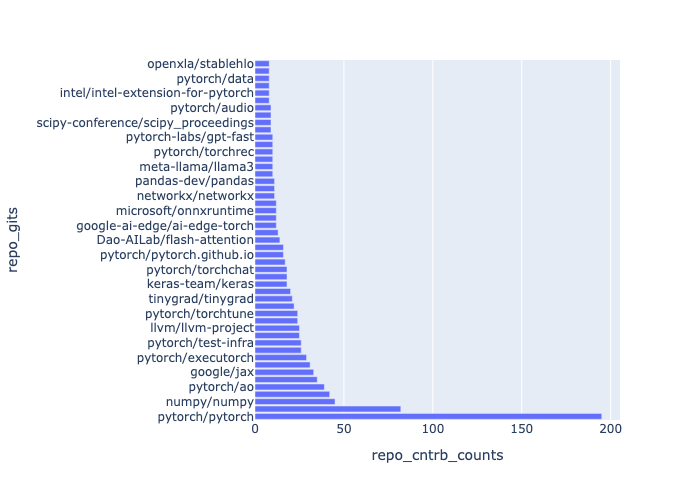

In [19]:
fig.write_image("repo_cntrb_counts.png")
Image(filename="repo_cntrb_counts.png")

In [20]:
# Here's the list of the top-50 most mutual repos among pagerank-top contributors
df_for_fig[:FINAL_NUM_COMMON_REPOS]

,repo_gits,repo_cntrb_counts
93,pytorch/pytorch,195
113,tensorflow/tensorflow,82
0,NaN,64
136,numpy/numpy,45
112,openxla/xla,42
812,pytorch/ao,39
832,pytorch/tutorials,35
428,google/jax,33
149,scipy/scipy,31
99,pytorch/executorch,29


In [21]:
df_for_fig.to_csv('new_repos.csv')

## Conclusion

After running the PageRank algorithm on AI repositories, several key observations and takeaways have been made:

##### 1. Significance of Seed Projects
-  Expected Involvement: As anticipated, the repositories within the original seed projects (those identified as being part of the AI/ML ecosystem) prominently feature among the top PageRank results. This indicates that contributors to these seed projects also tend to contribute to other significant projects within the AI space.
- Interpretation: The inclusion of seed projects among the top-ranked repositories confirms their centrality in the AI ecosystem. These projects are influential not only because of their individual importance but also due to their role in connecting various contributors within the broader AI community.
##### 2. Discovery of New Influential Repositories
- Emerging Projects: The analysis also identified repositories that were not part of the initial seed list but have emerged as significant through mutual contributor involvement like `pytorch/ao`, `openxla/xla`, `google/jax` etc. Google's jax is one of the key repositories which we did not add in our initial seed but it is found in the process. It is becoming increasingly popular in machine learning due to its efficiency in handling complex numerical tasks.
- Interpretation: Discovering these repositories provides valuable insights into the evolving landscape of AI development. These projects might be on the cutting edge of innovation, attracting contributors who are deeply embedded in the AI/ML ecosystem.
##### 3. Understanding Community Dynamics
- Mutual Involvement: The analysis highlights repositories that have significant mutual involvement, meaning they share contributors with other top repositories. This mutual involvement indicates strong community dynamics and collaboration within the AI space.
- Interpretation: The presence of these interconnected repositories suggests that certain areas of AI development are highly collaborative, with contributors working across multiple projects. This interconnectedness can be a sign of active development, knowledge sharing, and rapid advancement within the field.


## Next Steps

Set the 'seed' of another cycle of discovery to these 50 repos, called seed_1 (the successor to seed_0). Using this new, more inclusive seed_1, build a new collaboration network and rank the contributors in the new network. We infer that there will be significant overlap between those that are most involved in the seed_0 analysis phase as those identified  in the seed_1 analysis phase. 

Re-run this analysis, producing a prospective seed_2. Repeat, eventually generating seed_n. When seed_(n-1) is sufficiently similar to seed_n, we'll conclude that the identified "neighborhood" of the final seed repos has converged.

As an interesting alternate thread, consider the use of pagerank-central contributors as done in this notebook. Instead of finding repos of largest mutuality, use the Events themselves with appropriate filtering to find those projects of highest sub-population involvement, at least numerically, and compare against this [notebook](../project_discovery/repo_discovery/repo_discovery.ipynb).

Having a set of repos we can confidently say are "highly mutual" at least, we can use network science to visualize the neighborhood connection over time (notebooks/graph_analysis/approaches). 